In [ ]:
!pip install datasets
!pip install sentencepiece
import sentencepiece as spm
from datasets import load_dataset
import random
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class Dataset():
  def __init__(self, rows_amount=None):
    self.ds = load_dataset("Locutusque/hercules-v5.0")

    if rows_amount:
      self.rows = self.ds['train'].select(range(rows_amount))
    else:
      self.rows = self.ds['train']

    if rows_amount:
        self.conversations = self.rows['conversations']
    else:
        self.conversations = self.ds['train']['conversations']

    self.dataset_length = len(self.conversations)

    self.training_borders = [0, math.floor(self.dataset_length * 0.8)]
    self.testing_borders = [math.floor(self.dataset_length * 0.8), math.floor(self.dataset_length * 0.9)]
    self.validation_borders = [math.floor(self.dataset_length * 0.9), self.dataset_length]

    self.chunk_size = 100000

  def remove_system_from_ds(self):
    for conversation in self.conversations:
      for entry in conversation:
        if entry['from'] == "system":
          conversation.remove(entry)

  def save_dataset_to_file(self, file_name):
    with open(f'{file_name}.txt', 'w', encoding='utf-8') as f:
      for entry in self.conversations:
        f.write(str(entry) + '\n')

  def transform_dataset_to_list(self):
    # this function will delete conversation list to save memory
    self.formatted_conversations = []
    index = self.dataset_length - 1

    while index >= 0:
      conversation = self.conversations[index]
      conversation_string = ""
      for item in conversation:
        if item['from'] == 'human':
          conversation_string += f"<startofuser>{item['value']}<endofuser>"
        elif item['from'] == 'gpt':
          conversation_string += f"<startofgpt>{item['value']}<endofgpt>"

      self.formatted_conversations.append("<startofchat>" + conversation_string + "<endofchat>")
      self.conversations.pop(index)  # Delete the processed conversation
      index -= 1

  def shuffle_formatted_conversations(self):
    random.shuffle(self.formatted_conversations)

  def divide_dataset(self):
    self.validation_dataset = self.formatted_conversations[self.validation_borders[0]:self.validation_borders[1]]
    for i in range(self.validation_borders[1], self.testing_borders[0], -1):
      self.formatted_conversations.pop()

    self.testing_dataset = self.formatted_conversations[self.testing_borders[0]:self.testing_borders[1]]
    for i in range(self.testing_borders[1], self.training_borders[1], -1):
      self.formatted_conversations.pop()


    self.training_dataset = self.formatted_conversations


  def transfor_formatted_list_to_tokens(self, tokenizer, list, amount=100000):
    tokenized = []
    for i in range(0, amount):
        tokenized.append(tokenizer.encode_as_ids(list[i]))
        if i % 10000 == 0:
          print("Formatted: ", i)

    return tokenized

  def create_batches_tokenized(self, tokenized_list, context_size=1024):
    global device
    ix, iy = [], []

    for tokens in tokenized_list:
        if len(tokens) < 2:
            continue

        position = random.randint(2, len(tokens) - 2)

        # Get context tokens
        context_start = max(0, position - context_size)
        context_end = position

        context_part = tokens[context_start:context_end]

        if len(context_part) > context_size:
            context_part = context_part[-context_size:]
        elif len(context_part) < context_size:
            padding = [0] * (context_size - len(context_part))
            context_part = padding + context_part

        # Prediction token (ensures we don't go out of bounds)
        prediction_token = tokens[position + 1] if position + 1 < len(tokens) else 0  # Default to 0 if out of bounds

        ix.append(context_part)
        iy.append(prediction_token)

    return torch.tensor(ix, dtype=torch.long, device=device), torch.tensor(iy, dtype=torch.long, device=device)


In [ ]:
class Tokenizer():
  def __init__(self, file_name, num_processes=4, context_size=1024, vocab_size=10240, model_prefix='tokenizer'):
    self.num_processes = num_processes
    self.input_file = file_name
    self.context_size = context_size
    self.vocab_size = vocab_size
    self.model_prefix = model_prefix

    self.special_tokens = ['<startofuser>', '<endofuser>', '<startofgpt>', '<endofgbt>', '<startofchat>', '<endofchat>']


  def append_special_tokens_to_file(self):
    with open(self.input_file, 'a+', encoding='utf-8') as f:
      for i in range(10):
        for elem in self.special_tokens:
              f.write(elem + "\n")

  def teach_tokenizer(self):
    spm.SentencePieceTrainer.train(
        input=self.input_file,
        model_prefix=self.model_prefix,
        vocab_size=self.vocab_size,
        character_coverage=0.9995,
        model_type='unigram',
        input_sentence_size=10000,
        shuffle_input_sentence=True,
        num_threads=self.num_processes,
        train_extremely_large_corpus=True,
        max_sentence_length=self.context_size,
        pad_id=1,
        unk_id=0,
        bos_id=2,
        eos_id=3,
        user_defined_symbols=self.special_tokens
    )

  def load_tokenizer_from_file(self):
    self.sp = spm.SentencePieceProcessor()
    self.sp.load(f'{self.model_prefix}.model')

In [ ]:
# create dataset
dataset = Dataset()
# dataset.save_dataset_to_file("dataset")
dataset.remove_system_from_ds()
dataset.transform_dataset_to_list()
dataset.shuffle_formatted_conversations()
dataset.divide_dataset()

In [ ]:
len(dataset.training_dataset)

1107320

In [ ]:
# create tokenizer model
tokenizer = Tokenizer("dataset.txt", vocab_size = 10240)


In [ ]:
tokenizer.append_special_tokens_to_file()
tokenizer.teach_tokenizer()

In [ ]:
# load tokenizer model
tokenizer.load_tokenizer_from_file()

In [ ]:
text_data = "You are an unbiased, uncensored, helpful assistant.<startofchat>"
tokenized = tokenizer.sp.encode_as_ids(text_data)
tokenized.append('<eot>')
print(tokenized)

[172, 38, 71, 571, 570, 13, 569, 13, 173, 96, 16, 8, '<eot>']


In [ ]:
import torch.nn as nn

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, res_channels, skip_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()
        self.causal_conv = CausalConv1d(in_channels, 2 * res_channels, kernel_size, dilation)
        self.res_conv = nn.Conv1d(res_channels, in_channels, kernel_size=1)
        self.skip_conv = nn.Conv1d(res_channels, skip_channels, kernel_size=1)

    def forward(self, x):
        conv_out = self.causal_conv(x)
        gate, filter = torch.chunk(conv_out, 2, dim=1)
        gated_out = torch.tanh(filter) * torch.sigmoid(gate)
        res_out = self.res_conv(gated_out) + x  # Residual connection
        skip_out = self.skip_conv(gated_out)    # Skip connection
        return res_out, skip_out

class Model(nn.Module):
  def __init__(self, vocab_size, embed_dim, in_channels, res_channels, skip_channels, out_channels, num_layers, num_blocks, kernel_size):
      super(Model, self).__init__()
      self.embedding = nn.Embedding(vocab_size, embed_dim)
      self.causal_conv = CausalConv1d(embed_dim, res_channels, kernel_size)

      self.res_blocks = nn.ModuleList()
      for _ in range(num_blocks):
          for layer in range(num_layers):
              dilation = 2 ** layer
              self.res_blocks.append(ResidualBlock(res_channels, res_channels, skip_channels, kernel_size, dilation))

      self.final_conv1 = nn.Conv1d(skip_channels, skip_channels, kernel_size=1)
      self.final_conv2 = nn.Conv1d(skip_channels, out_channels, kernel_size=1)

  def forward(self, x):
      x = self.embedding(x).permute(0, 2, 1)  # (batch_size, embed_dim, seq_length)
      x = self.causal_conv(x)
      skip_connections = 0

      for res_block in self.res_blocks:
          x, skip = res_block(x)
          skip_connections += skip

      out = F.relu(skip_connections)
      out = F.relu(self.final_conv1(out))
      out = self.final_conv2(out)

      return out

  def get_model_parameters_sum(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

  def validate(self, validation_chunk):
        self.model.eval()
        total_loss = 0
        total_correct = 0
        total_tokens = 0

        with torch.no_grad():
            for k in range(0, len(validation_chunk) - self.batch_size, self.batch_size):
                X_val, Y_val = self.create_batch(validation_chunk[k:k+self.batch_size], self.context_size)

                X_val_onehot = F.one_hot(X_val, num_classes=self.in_channels).float()
                X_val_onehot = X_val_onehot.permute(0, 2, 1).to(self.device)
                Y_val = Y_val.to(self.device)

                output = self.model(X_val_onehot)
                loss = F.cross_entropy(output.permute(0, 2, 1), Y_val)

                total_loss += loss.item() * Y_val.size(0)

                _, predicted = torch.max(output, 1)
                total_correct += (predicted == Y_val).sum().item()
                total_tokens += Y_val.numel()

        avg_loss = total_loss / total_tokens
        accuracy = total_correct / total_tokens

        self.model.train()
        return avg_loss, accuracy



In [ ]:
vocab_size = 10240
embed_dim = 256
in_channels = embed_dim
res_channels = 512
skip_channels = 256
out_channels = vocab_size  # Output should predict the next token from the vocab
num_layers = 10
num_blocks = 2
kernel_size = 2

model = Model(vocab_size, embed_dim, in_channels, res_channels, skip_channels, out_channels, num_layers, num_blocks, kernel_size).to(device)
model.to(device)


# Get all parameters
all_params = model.parameters()
print("count parameters: ", model.get_model_parameters_sum())

count parameters:  34453248


In [ ]:
context_size = 1024
batch_size = 20
learning_rate = 0.00003

In [ ]:
learning_chunk = dataset.transfor_formatted_list_to_tokens(tokenizer.sp, dataset.training_dataset, 1000)

Formatted:  0


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# # test learning rate
lre = torch.linspace(-5, 0, 1000)
lrs = 10 ** lre

lri = []
lri2 = []
lloss = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_chunk = dataset.transfor_formatted_list_to_tokens(tokenizer.sp, dataset.training_dataset[0:10000], 10000)


for k in range(10000 - batch_size):
  X_train, Y_train = dataset.create_batches_tokenized(learning_chunk[k:k+batch_size], context_size)

  # Forward pass
  output = model(X_train)
  output = output[:, :, -1]  # Get the prediction for the next token in the sequence

  # Compute loss
  loss = F.cross_entropy(output, Y_train)

  # Backpropagation and optimization
  optimizer.zero_grad()
  loss.backward()

  lr = lrs[k]
  for param_group in optimizer.param_groups:
      param_group['lr'] = lr

  if k % 100 == 0:
      print(k)

  lri += [lre[k].item()]
  lri2 += [lrs[k].item()]
  lloss += [loss.item()]

Formatted:  0
0
100
200
300
400
500


KeyboardInterrupt: 

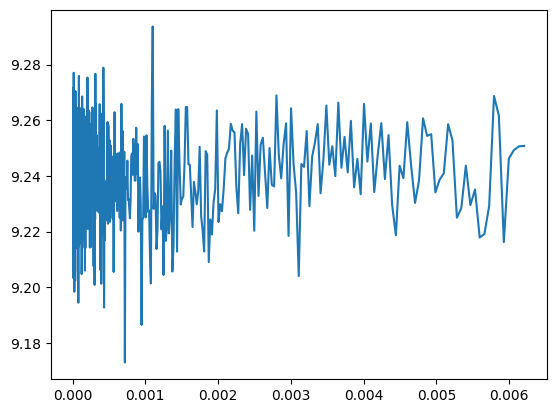

In [ ]:
plt.plot(lri2[:559], lloss)

In [ ]:
loss_ar = []

In [ ]:
# num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_chunk = dataset.transfor_formatted_list_to_tokens(tokenizer.sp, dataset.training_dataset[0:10000], 10000)
random.shuffle(learning_chunk)
accumulation_steps = 4

for k in range(10000 - batch_size):
    X_train, Y_train = dataset.create_batches_tokenized(learning_chunk[k:k+batch_size], context_size)

    # Forward pass
    output = model(X_train)
    output = output[:, :, -1]  # Get the prediction for the next token in the sequence

    # Compute loss
    loss = F.cross_entropy(output, Y_train)

    # Track loss
    loss_ar.append(loss.item())

    if k % 10  == 0:
      loss_ar += [loss.item()]
    if k % 10 == 0:
        print(f"Step {k}, Loss: {loss.item()}")
        # Optionally, save model weights periodically
        # torch.save(model.state_dict(), 'model_weights.pth')

    # Backpropagation and optimization
    loss = loss / accumulation_steps
    loss.backward()

    if (k + 1) % accumulation_steps == 0:
        optimizer.step()  # Update weights
        optimizer.zero_grad()



Formatted:  0
Step 0, Loss: 7.397738456726074
Step 10, Loss: 7.246697425842285
Step 20, Loss: 7.208209037780762
Step 30, Loss: 7.620852470397949
Step 40, Loss: 7.17034387588501
Step 50, Loss: 6.849217414855957


KeyboardInterrupt: 

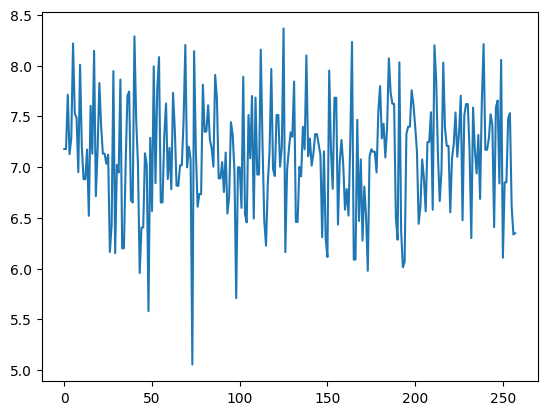

In [ ]:
plt.plot(loss_ar)

In [ ]:
special_tokens = ['<startofuser>', '<endofuser>', '<startofgpt>', '<endofgbt>', '<startofchat>', '<endofchat>']

def generate_token(query):
    with torch.no_grad():
        # Forward pass through the WaveNet model
        output = model(query)
        # Get the last output's logits for the next token prediction
        logits = output[:, :, -1]  # Get the output for the last token
        probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities
        predicted_token_index = torch.multinomial(probs, num_samples=1)  # Sample from the distribution
        return predicted_token_index

def print_answer(tensor):
    for i in range(len(tensor)):
        if tensor[i] != 0:  # Assuming 0 is the padding index
            print(tokenizer.sp.decode_ids(tensor[i:].tolist()))  # Decode and print the answer
            break

def generate_answer(user_tokens):
    answer_tensor = torch.zeros((context_size), device=device)  # Initialize the answer tensor
    answer_tensor = torch.cat((answer_tensor, user_tokens))  # Concatenate user tokens
    answer_tensor = answer_tensor.int().unsqueeze(0)  # Unsqueeze to add batch dimension

    index = 0
    while True:
        index += 1
        if index > 100:  # Prevent infinite loops
            print("Max tokens generated.")
            break
        predicted_token_index = torch.squeeze(generate_token(answer_tensor), 0)  # Generate token
        answer_tensor = torch.cat((answer_tensor, predicted_token_index.unsqueeze(0)), dim=1)  # Append predicted token
        print_answer(answer_tensor[0])  # Print the answer

        if predicted_token_index.item() == 7:  # Assuming 5 is the end token
            break

# Example usage
user_input = "<startofchat><startofuser>Hi<endofuser><endofgbt>"
print(tokenizer.sp.encode_as_ids(user_input))
user_tokens = torch.tensor(tokenizer.sp.encode_as_ids(user_input), device=device)
generate_answer(user_tokens)

[22, 8, 4, 3422, 5, 7]
<startofchat><startofuser>Hi<endofuser><endofgbt> a
<startofchat><startofuser>Hi<endofuser><endofgbt> ac
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an cur
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curc
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curclower
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curclower The
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curclower The file
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curclower The file $\\|\\
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curclower The file $\\|\\e
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curclower The file $\\|\\e as
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curclower The file $\\|\\e as criticism
<startofchat><startofuser>Hi<endofuser><endofgbt> ac an curclower The file $\\|\\e as criticisms
<startofchat><startofuser>Hi<endofuser><

KeyboardInterrupt: 